In [28]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import r2_score, root_mean_squared_error
from torch.utils.data import Dataset, TensorDataset, DataLoader

from models.fno import FNO
from models.losses import LpLoss, H1Loss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data_dir = 'data/2024-08-06'

# Read input function
ax_train_path = os.path.join(data_dir, 'ax_train.pt')
ax_test_path = os.path.join(data_dir, 'ax_test.pt')

ax_train = torch.load(ax_train_path)
ax_test = torch.load(ax_test_path)


# Read target function
ux_train_path = os.path.join(data_dir, 'ux_train.pt')
ux_test_path = os.path.join(data_dir, 'ux_test.pt')

ux_train = torch.load(ux_train_path)
ux_test = torch.load(ux_test_path)

In [4]:
def normalise(dataset, key, channel_mean=None, channel_std=None):
    if channel_mean is None:
        arr = dataset[key].permute(1, 0, 2, 3).flatten(1)
        channel_mean = arr.mean(1)
        channel_std = arr.std(1)
    normalised_dataset = ((dataset[key].permute(0, 2, 3, 1) - channel_mean)/channel_std).permute(0, 3, 1, 2)
    return normalised_dataset, channel_mean, channel_std

In [5]:
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [6]:
def training_loop(model, train_dl, train_loss, optimizer, scheduler, n_epochs=500):

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(n_epochs)):

        avg_loss = 0
        avg_lasso_loss = 0
        model.train()
        train_err = 0.0

        avg_test_loss = 0
        test_err = 0.0

        for idx, sample in enumerate(train_dl):

            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            loss.backward()

            optimizer.step()
            train_err += loss.item()

            with torch.no_grad():
                avg_loss += loss.item()
            
            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to('cpu')

        if (epoch + 1) % 5:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_err)
            else:
                scheduler.step()

        train_err /= len(train_dl)
        avg_loss  /= n_epochs


        train_losses.append(avg_loss)
        # test_losses.append(avg_test_loss)

        # print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        if (epoch + 1) == n_epochs:
            print(f'Epoch: {epoch+1} loss: {avg_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        
                
    return model, train_losses

In [7]:
def train_model(train_loader, n_modes=(16, 10), in_channels=2, 
                hidden_channels=64, projection_channels=64, n_epochs=200):
    
    # Losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = h1loss
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    # Model configuration
    n_modes = n_modes
    model = FNO(n_modes=n_modes, in_channels=in_channels, 
                hidden_channels=hidden_channels, 
                projection_channels=projection_channels).float()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-2,
                                weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.975)
    
    model, train_losses = training_loop(model, train_loader, 
                          train_loss, optimizer, 
                          scheduler, n_epochs=n_epochs)
    
    return model, train_losses

In [8]:
train_data_dict = {'ax': ax_train, 'ux': ux_train}
test_data_dict = {'ax': ax_test, 'ux': ux_test}

In [9]:
# Normalize train tensor
ax_train_normalized, ax_channel_mean, ax_channel_std = normalise(train_data_dict, 'ax')
ux_train_normalized, ux_channel_mean, ux_channel_std = normalise(train_data_dict, 'ux')

# Normalize test tensor
ax_test_normalized, _, _ = normalise(test_data_dict, 'ax', ax_channel_mean, ax_channel_std)
ux_test_normalized, _, _ = normalise(test_data_dict, 'ux', ux_channel_mean, ux_channel_std)

In [10]:
train_ds = DictDataset(ax_train_normalized, ux_train_normalized)
test_ds = DictDataset(ax_test_normalized, ux_test_normalized)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [11]:
model, train_losses = train_model(train_dl, in_channels=2, n_modes=(16, 16),
                    projection_channels=64, n_epochs=1000)

100%|██████████| 1000/1000 [21:12<00:00,  1.27s/it]

Epoch: 1000 loss: 0.0577 lr: 0.0000, 0.0000


In [36]:
def plot_results(ax, ux, ux_hat, filepath=None):

    fig, axes = plt.subplots(1, 4, figsize=(18, 3))
    
    im = axes[0].imshow(ax[0], origin='lower')
    axes[0].set_title('$h(x)$')
    fig.colorbar(im, orientation='vertical')
    
    
    im = axes[1].imshow(ax[1], origin='lower')
    axes[1].set_title('$p(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[2].imshow(ux[0], vmax=ux_hat.max(), vmin=ux_hat.min(), origin='lower')
    axes[2].set_title('$\phi(x)$')
    fig.colorbar(im, orientation='vertical')
    
    im = axes[3].imshow(ux_hat[0], origin='lower')
    axes[3].set_title('$\phi_{pred}(x)$')
    fig.colorbar(im, orientation='vertical')
    
    if filepath is not None:
        fig.savefig(filepath, bbox_inches='tight')

    return fig

In [40]:
def sample_and_evaluate(model, ds, n=4, train=True):
    # Randomly sample indices
    indices = np.random.randint(0, len(ds), n)
    sample = ds[indices]

    # Plot dir
    plot_path = f'results/plots/{str(dt.date.today())}/'
    if train:
        plot_path = os.path.join(plot_path, 'train')
    else:
        plot_path = os.path.join(plot_path, 'test')
    os.makedirs(plot_path, exist_ok=True)

    # Generate prediction
    for k, v in sample.items():
        if hasattr(v, 'to'):
            sample[k] = v.to(device)
    with torch.no_grad():
        ux_test_hat = model(**sample).to('cpu').numpy()

    # Evaluate and save plot
    r2_value= np.zeros(n)
    rmse_value = np.zeros(n)
    for i in range(n):
        _ = plot_results(sample['x'][i].cpu(), sample['y'][i].cpu(), ux_test_hat[i], 
                         filepath=os.path.join(plot_path, f'{i+1}.png'))

        r2_value[i] = r2_score(sample['y'][i].cpu().flatten(), ux_test_hat[i].flatten())
        rmse_value[i] = root_mean_squared_error(sample['y'][i].cpu().flatten(), ux_test_hat[i].flatten())

    return r2_value, rmse_value
    


(array([0.99714047, 0.99549854, 0.96762711, 0.99690568]),
 array([0.00807516, 0.00743971, 0.07534844, 0.03528348]))

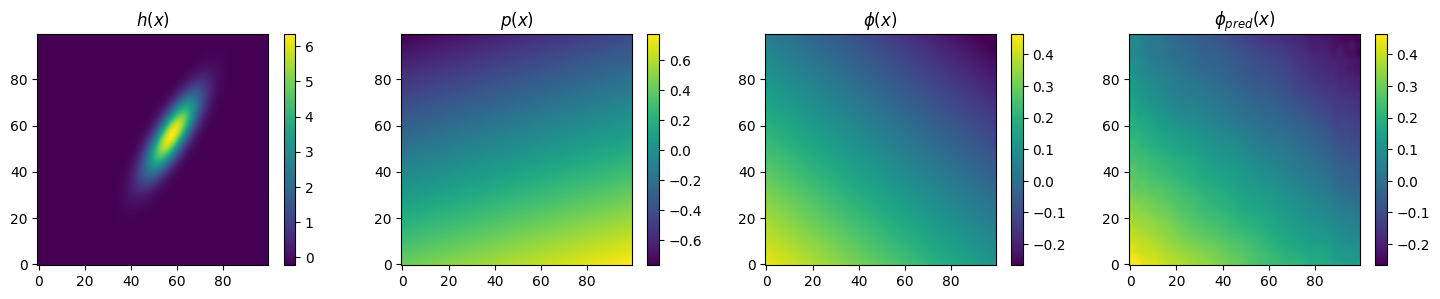

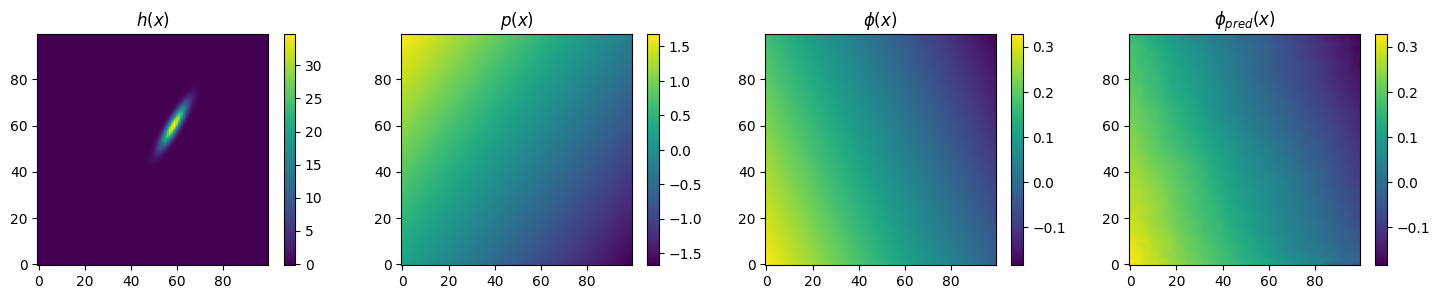

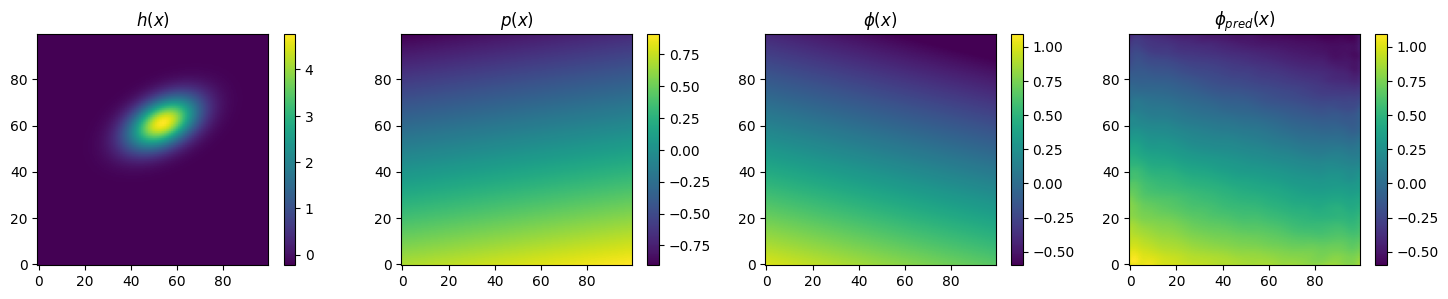

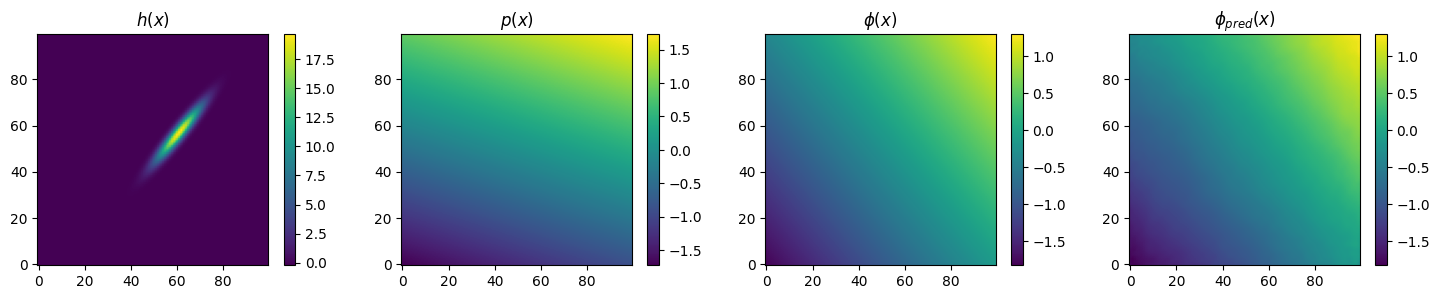

In [41]:
sample_and_evaluate(model, train_ds, train=True)

(array([0.97885162, 0.9623791 , 0.99343377, 0.97851515]),
 array([0.06986538, 0.04960267, 0.1568234 , 0.22076188]))

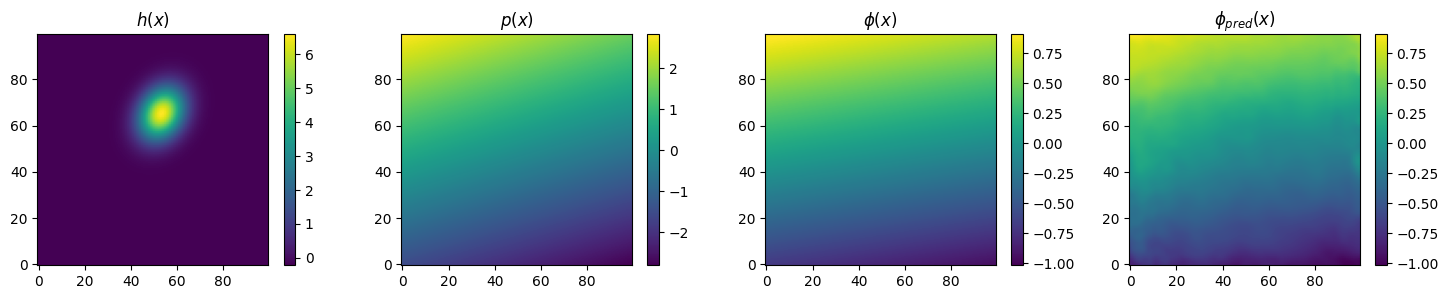

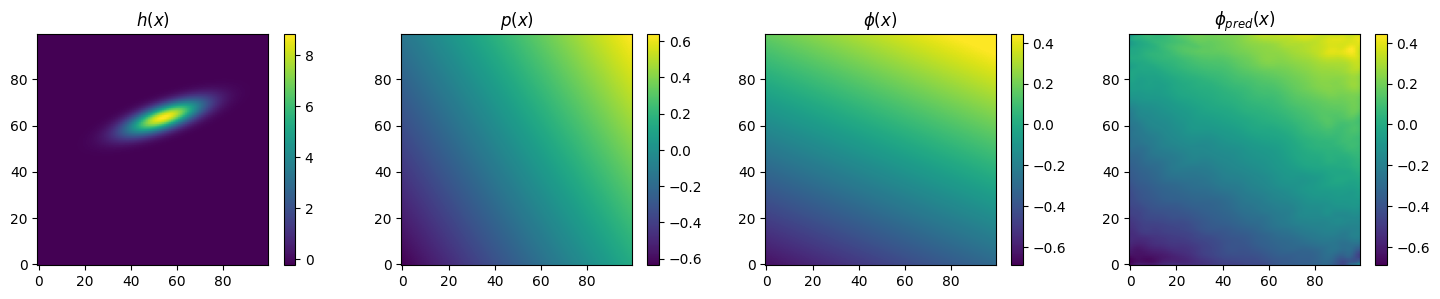

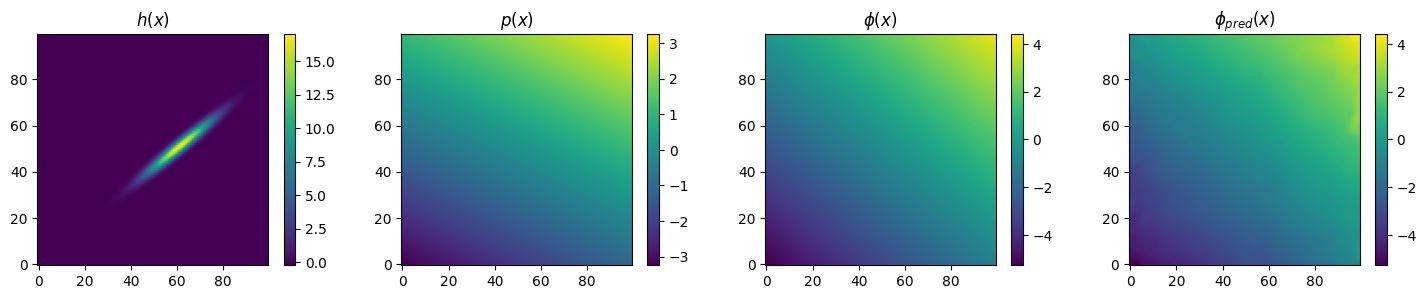

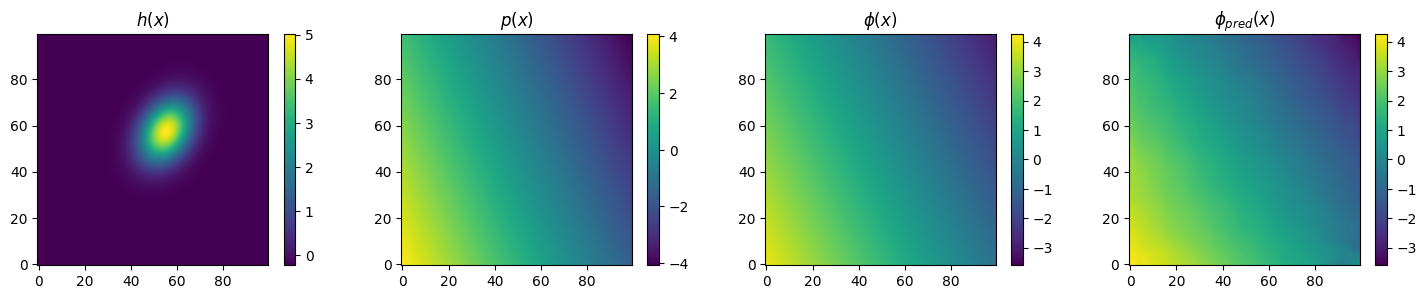

In [42]:
sample_and_evaluate(model, test_ds, train=False)

In [ ]:
# ux_unscaled = val_ux.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]
# ux_hat_unscaled = ϕx_hat.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]

# r2_error = r2_score(ux_unscaled, ux_hat_unscaled)
# rmse = root_mean_squared_error(ux_unscaled, ux_hat_unscaled)

In [55]:
def evaluate(model, dl, ux):
    ux_hat = []
    for sample in dl:
        
        # Generate prediction
        for k, v in sample.items():
            if hasattr(v, 'to'):
                sample[k] = v.to(device)
    
        with torch.no_grad():
            ux_hat.append(model(**sample).to('cpu').numpy())
    
    ux_hat = np.concatenate(ux_hat, axis=0)
    
    r2_value = r2_score(ux.flatten(), ux_hat.flatten())
    rmse_value = root_mean_squared_error(ux.flatten(), ux_hat.flatten()).item()
    return r2_value, rmse_value

In [56]:
evaluate(model, train_dl, ux_train_normalized)

(-0.8158540725708008, 1.3475362062454224)

In [58]:
evaluate(model, test_dl, ux_test_normalized)

(0.9627121686935425, 0.18215493857860565)

In [15]:
# def validate(model, val_dataset, directory, ux_mean, ux_std, interpolate=True):
#     val_ax = val_dataset['ax']
#     val_ux = val_dataset['ux']
    
#     l2loss = LpLoss(d=2, p=2)
#     h1loss = H1Loss(d=2)
    
#     with torch.no_grad():
#         ϕx_hat = model(val_ax.to(device))
#         error = h1loss(ϕx_hat, val_ux.to(device))
#         print(f"Validation H1Loss: {error.item():.2f}")
    
#     n, c, l, b = ϕx_hat.shape
#     n_root = int(np.sqrt(n))
#     ϕx_hat = ϕx_hat.reshape((n_root, n_root, c, l, b))

#     if interpolate:
#         for i in range(2, n_root-1, 2):
#             for j in range(2, n_root-1, 2):
#                 ϕx_hat[i, j, :, :, :b//2] = (ϕx_hat[i, j, :, :, :b//2] + ϕx_hat[i, j-1, :, :, b//2:])/2
#                 ϕx_hat[i, j, :, :, b//2:] = (ϕx_hat[i, j, :, :, b//2:] + ϕx_hat[i, j+1, :, :, :b//2])/2
#                 ϕx_hat[i, j, :, :l//2, :] = (ϕx_hat[i, j, :, :l//2, :] + ϕx_hat[i-1, j, :, l//2:, :])/2
#                 ϕx_hat[i, j, :, l//2:, :] = (ϕx_hat[i, j, :, l//2:, :] + ϕx_hat[i+1, j, :, :l//2, :])/2
            

#     # skip alternate rows and cols
#     ϕx_hat = ϕx_hat[::2, ::2].cpu().numpy()
#     val_ax = val_ax.reshape((n_root, n_root, 4, l, b))[::2, ::2].numpy()
#     val_ux = val_ux.reshape((n_root, n_root, 1, l, b))[::2, ::2].numpy()

#     ux_unscaled = val_ux.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]
#     ux_hat_unscaled = ϕx_hat.flatten() * ux_std.numpy()[0] + ux_mean.numpy()[0]

#     r2_error = r2_score(ux_unscaled, ux_hat_unscaled)
#     rmse = root_mean_squared_error(ux_unscaled, ux_hat_unscaled)

#     # ux_hat
#     ϕx_hat = np.concatenate([ϕx_hat[:, i] for i in range(n_root//2)], axis=-1)
#     ϕx_hat = np.concatenate([ϕx_hat[i] for i in range(n_root//2)], axis=-2)
    
#     # ax
#     val_ax = np.concatenate([val_ax[:, i] for i in range(n_root//2)], axis=-1)
#     val_ax = np.concatenate([val_ax[i] for i in range(n_root//2)], axis=-2)
    
#     # ux
#     val_ux = np.concatenate([val_ux[:, i] for i in range(n_root//2)], axis=-1)
#     val_ux = np.concatenate([val_ux[i] for i in range(n_root//2)], axis=-2)

#     # plot results
#     plot_results(val_ax, val_ux, ϕx_hat, filepath=f'plots/{directory}.png')
    
#     return error.item(), r2_error, rmse

In [16]:
# res_df = pd.DataFrame(res_list)
# res_df.to_csv('results.csv', index=False)